# Titanic Dataset EDA

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [2]:
titanic_train = pd.read_csv("../data/train.csv")
titanic_test = pd.read_csv("../data/test.csv")
titanic_train_baseline = titanic_train.copy()

In [3]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic_train[titanic_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [7]:
# Removing these two passengers as this seems to be a data entry error or these passengers missed the trip
# and didn't board the ship
titanic_train = titanic_train[~titanic_train['Embarked'].isnull()]

In [8]:
# Check for duplicates records
sum(titanic_train.duplicated())

0

In [9]:
# Confirming that duplicate ticket values indicate passengers sharing the same room
titanic_train[titanic_train["Ticket"].duplicated(keep=False)].sort_values(by=['Ticket'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.500,B77,S
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.500,B77,S
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.500,B79,S
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.650,E67,S
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.650,E68,S
...,...,...,...,...,...,...,...,...,...,...,...,...
436,437,0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.375,NaN,S
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.375,NaN,S
86,87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.375,NaN,S
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.000,B22,S


## Helper Functions

In [67]:
def calc_survival_rate(df):
    survived = sum(df['Survived'] == 1)
    total = len(df)
    return round(survived/total*100,2)

def calc_survival_count(df):
    survived = sum(df['Survived'] == 1)
    return survived

def calc_age_cat(passenger):
    if passenger['Age'] <= 13:
        return "Child"
    elif passenger['Age'] <= 20:
        return "Youth"
    elif passenger['Age'] <= 64:
        return "Adult"
    else:
        return "Senior"
    
def calc_family_role(passenger,df):
    if (passenger["Parch"] ==2 and passenger["SibSp"] >= 0) or (passenger["Parch"] ==1 and passenger["SibSp"] > 1):
        return "Child"
    elif passenger["Parch"] ==0 and passenger["SibSp"] > 1:
        return "Sibling"
    elif passenger["Parch"] > 2:
        return "Parent"
    elif passenger["Parch"] == 0 and passenger["SibSp"] == 1:
        fam_name = passenger["Name"].split(",")[0]
        fam_df = df[(df["Name"].str.startswith(fam_name)) & (df["Ticket"]==passenger["Ticket"])]
        
        if len(fam_df[fam_df["Sex"]==0]) == 0 or len(fam_df[fam_df["Sex"]==1])==0:
            return "Sibling"
        else:
            female_fam = fam_df[fam_df["Sex"]==1]
            female_firstname= female_fam["Name"].values[0].split(",")[1]
            female_prefix = female_firstname.split(".")[0].strip()
            if female_prefix == "Mrs":
                return "Spouse"
            else:
                return "Sibling"
        
    elif passenger["Parch"] <= 2 and passenger["SibSp"] == 1:
        fam_name = passenger["Name"].split(",")[0]
        fam_df = df[(df["Name"].str.startswith(fam_name)) & (df["Ticket"]==passenger["Ticket"])]
        fam_age_df = df[df["Age"]>passenger["Age"]]
            
        if len(fam_age_df) >= 2:
            return "Sibling"
        else:
            return "Parent"
            
    elif passenger["Parch"] == 1 and passenger["SibSp"] == 0:
        fam_name = passenger["Name"].split(",")[0]
        fam_df = df[(df["Name"].str.startswith(fam_name)) & (df["Ticket"]==passenger["Ticket"])]

        if passenger["Age"] == max(fam_df["Age"]):
            return "Parent"
        else:
            return "Child"
    else:
        return "Single"
        
    
def calc_passenger_profile_avg_age(df,passenger):
    passenger_pclass = passenger['Pclass']
    passenger_sex = passenger['Sex']
    passenger_sibsp = passenger['SibSp']
    passenger_parch = passenger['Parch']
    passenger_embarked = passenger['Embarked']
    
    profile = ['Pclass','Sex','SibSp','Parch','Embarked']
    passenger_profile = {'Pclass': passenger_pclass,'Sex': passenger_sex,'SibSp':passenger_sibsp,'Parch':passenger_parch,'Embarked':passenger_embarked}
    
    profile_avg_age = df.groupby(profile,as_index = False)['Age'].mean()
    
    i = len(passenger_profile)
    for n in range(i):
        profile_col = profile[n]
        profile_avg_age = profile_avg_age[profile_avg_age[profile_col]==passenger_profile[profile_col]]
    
    while len(profile_avg_age) == 0 or pd.isna(profile_avg_age["Age"].values[0]) :
        i -= 1
        profile_avg_age = df.groupby(profile[:i],as_index = False)['Age'].mean()
        
        for n in range(i):
            profile_col = profile[n]
            profile_avg_age = profile_avg_age[profile_avg_age[profile_col]==passenger_profile[profile_col]]
            
    return profile_avg_age['Age'].values[0]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

def plot_survival_bar(df,col=None,ax=None,title=None):
    
    if col:
        col_vals = list(set(df[col].values))

        survived = [len(df[(df["Survived"]==1) & (df[col]==c)]) for c in col_vals]
        not_survived = [len(df[(df["Survived"]==0) & (df[col]==c)]) for c in col_vals]

        survival_rates = [calc_survival_rate(df[df[col]==c]) for c in col_vals]
        
        if not ax:
            fig, ax = plt.subplots(figsize=(15,5))
            
        
        s = ax.bar(col_vals, survived, label='Survived')
        d = ax.bar(col_vals, not_survived, bottom=survived,
               label='Died')

        ax.bar_label(s,survival_rates)
        if title:
            ax.set_title('{} Survival Rate by {}'.format(title,col))
        else:
            ax.set_title('Survival Rate by {}'.format(col))   
        ax.legend()
    else:
        survived = len(df[df["Survived"]==1])
        not_survived = len(df[df["Survived"]==0])

        survival_rate = [calc_survival_rate(df)]
        
        if not ax:
            fig, ax = plt.subplots(figsize=(15,5))

        s = ax.bar(["All Passengers"], survived, label='Survived')
        d = ax.bar(["All Passengers"], not_survived, bottom=survived,
               label='Died')

        ax.bar_label(s,survival_rate)
        ax.set_title('Survival Rate')
        ax.legend()
        
def plot_survival_subplots(df,x,group):
    group_list = list(set(df[group]))
    rows = math.ceil(len(group_list)/ 3)
    cols = min(len(group_list), 3) 
    
    fig, axs = plt.subplots(rows, cols,figsize=(15,5), constrained_layout=True)
  

    for i, ax in enumerate(axs.flat):
        if i == len(group_list): break
        g = group_list[i]
        group_df = df[df[group]==g]
        plot_survival_bar(group_df,x,ax,"{}={}".format(group,g))
            

def log_reg_train(train_df):
    # create X (features) and y (response)
    X = train_df.loc[:, train_df.columns != 'Survived']
    y = train_df['Survived']

    # use train/test split with different random_state values
    # we can change the random_state values that changes the accuracy scores
    # the scores change a lot, this is why testing scores is a high-variance estimate
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    # check classification scores of logistic regression
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_pred_proba = logreg.predict_proba(X_test)[:, 1]
    [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
    print('Train/Test split results:')
    print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
    print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
    print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

    idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))
    return logreg

def rf_train(train_df,gs=False,param_grid=None):
    # create X (features) and y (response)
    X = train_df.loc[:, train_df.columns != 'Survived']
    y = train_df['Survived']

    # use train/test split with different random_state values
    # we can change the random_state values that changes the accuracy scores
    # the scores change a lot, this is why testing scores is a high-variance estimate
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    
    if gs:
        clf=RandomForestClassifier()
        rf_gs = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
        rf_gs.fit(X_train, y_train)
        
        print(rf_gs.best_params_)
        
        criterion = rf_gs.best_params_['criterion']
        max_depth = rf_gs.best_params_['max_depth']
        max_features = rf_gs.best_params_['max_features']
        n_estimators = rf_gs.best_params_['n_estimators']
        
        rf= RandomForestClassifier(criterion=criterion,max_depth=max_depth,max_features=max_features,n_estimators=n_estimators)
        rf.fit(X_train,y_train)
    else:
        rf=RandomForestClassifier()
        rf.fit(X_train,y_train)
        
    feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
    
    y_pred=rf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",accuracy_score(y_test, y_pred))

    
    plt.figure(figsize=(10,6))
    
    sns.barplot(x=feature_imp, y=feature_imp.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()
    
    return rf

def cnf_matrix(clf,train_df):
    X = train_df.loc[:, train_df.columns != 'Survived']
    y = train_df['Survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    y_pred = clf.predict(X_test)
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print("Accuracy:",accuracy_score(y_test, y_pred))
    print("Precision:",precision_score(y_test, y_pred))
    print("Recall:",recall_score(y_test, y_pred))
    
def feature_selection(train_df,estimator):
    X = train_df.loc[:, train_df.columns != 'Survived']
    y = train_df['Survived']

    rfecv = RFECV(estimator, scoring='accuracy')
    rfecv.fit(X, y)
    
    selected_features = list(X.columns[rfecv.support_])
    selected_features.append('Survived')

    print("Optimal number of features: %d" % rfecv.n_features_)
    print('Selected features: %s' % list(X.columns[rfecv.support_]))
    print('Removed features: %s' % list(X.columns[~rfecv.support_]))

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=(10,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    return selected_features
    
def get_models(model):
    models = dict()
    # lr
    rfecv = RFECV(estimator=LogisticRegression())
    m = model
    models['lr'] = Pipeline(steps=[('s',rfecv),('m',m)])
    # rf
    rfecv = RFECV(estimator=RandomForestClassifier())
    m = model
    models['rf'] = Pipeline(steps=[('s',rfecv),('m',m)])
    # gbm
    rfecv = RFECV(estimator=GradientBoostingClassifier())
    m = model
    models['gbm'] = Pipeline(steps=[('s',rfecv),('m',m)])
    return models

def evaluate_model(model, train_df):
    X = train_df.loc[:, train_df.columns != 'Survived']
    y = train_df['Survived']
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

def evaluate_models(model,train_df):
    X = train_df.loc[:, train_df.columns != 'Survived']
    y = train_df['Survived']
    # get the models to evaluate
    models = get_models(model)
    # evaluate the models and store results
    results, names = list(), list()
    for name, m in models.items():
        scores = evaluate_model(m, train_df)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

In [11]:
titanic_train['FamilyRole'] = titanic_train.apply(lambda x: calc_family_role(x,pd.concat([titanic_train,titanic_test])), axis=1)
titanic_train["CabinLetter"] = titanic_train["Cabin"].apply(lambda x: x[0] if not pd.isna(x) else "N/A")
titanic_train['Age_fill'] = titanic_train.apply(lambda x: calc_passenger_profile_avg_age(titanic_train[~titanic_train["Age"].isna()],x) if pd.isna(x['Age']) else x['Age'],axis=1)
titanic_train['AgeCategory'] = titanic_train.apply(lambda x: calc_age_cat(x), axis=1)
titanic_train['Sex'] = titanic_train.apply(lambda x: {"female":1,"male":0}[x["Sex"]],axis=1)


In [12]:
titanic_train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age_fill
PassengerId,1.000000,-0.005028,-0.035330,-0.043136,0.033681,-0.057686,-0.001657,0.012703,0.047270
Survived,-0.005028,1.000000,-0.335549,0.541585,-0.082446,-0.034040,0.083151,0.255290,-0.087843
Pclass,-0.035330,-0.335549,1.000000,-0.127741,-0.365902,0.081656,0.016824,-0.548193,-0.395343
Sex,-0.043136,0.541585,-0.127741,1.000000,-0.099037,0.116348,0.247508,0.179958,-0.146750
Age,0.033681,-0.082446,-0.365902,-0.099037,1.000000,-0.307351,-0.187896,0.093143,1.000000
SibSp,-0.057686,-0.034040,0.081656,0.116348,-0.307351,1.000000,0.414542,0.160887,-0.274061
Parch,-0.001657,0.083151,0.016824,0.247508,-0.187896,0.414542,1.000000,0.217532,-0.202769
Fare,0.012703,0.255290,-0.548193,0.179958,0.093143,0.160887,0.217532,1.000000,0.106059
Age_fill,0.047270,-0.087843,-0.395343,-0.146750,1.000000,-0.274061,-0.202769,0.106059,1.000000


In [13]:
categories = ["AgeCategory","FamilyRole","CabinLetter","Pclass","Sex","Embarked"]
for cat in categories:
    titanic_train[cat] = titanic_train[cat].astype("category") 
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  889 non-null    int64   
 1   Survived     889 non-null    int64   
 2   Pclass       889 non-null    category
 3   Name         889 non-null    object  
 4   Sex          889 non-null    category
 5   Age          712 non-null    float64 
 6   SibSp        889 non-null    int64   
 7   Parch        889 non-null    int64   
 8   Ticket       889 non-null    object  
 9   Fare         889 non-null    float64 
 10  Cabin        202 non-null    object  
 11  Embarked     889 non-null    category
 12  FamilyRole   889 non-null    category
 13  CabinLetter  889 non-null    category
 14  Age_fill     889 non-null    float64 
 15  AgeCategory  889 non-null    category
dtypes: category(6), float64(3), int64(4), object(3)
memory usage: 82.7+ KB


In [14]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  889 non-null    int64   
 1   Survived     889 non-null    int64   
 2   Pclass       889 non-null    category
 3   Name         889 non-null    object  
 4   Sex          889 non-null    category
 5   Age          712 non-null    float64 
 6   SibSp        889 non-null    int64   
 7   Parch        889 non-null    int64   
 8   Ticket       889 non-null    object  
 9   Fare         889 non-null    float64 
 10  Cabin        202 non-null    object  
 11  Embarked     889 non-null    category
 12  FamilyRole   889 non-null    category
 13  CabinLetter  889 non-null    category
 14  Age_fill     889 non-null    float64 
 15  AgeCategory  889 non-null    category
dtypes: category(6), float64(3), int64(4), object(3)
memory usage: 82.7+ KB


In [15]:
cor = titanic_train.corr()

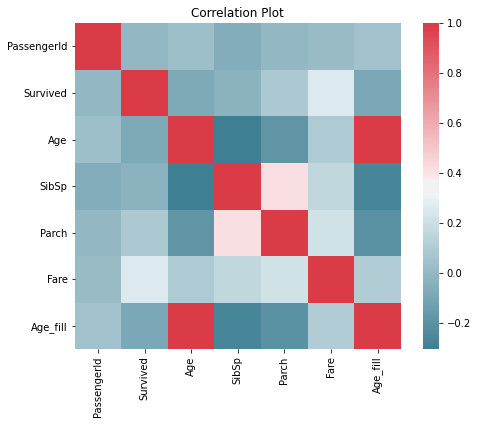

In [16]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [17]:
titanic_train_baseline["Age"].fillna(titanic_train_baseline["Age"].median(skipna=True), inplace=True)
titanic_train_baseline["Fare"].fillna(titanic_train_baseline["Fare"].median(skipna=True), inplace=True)
titanic_train_baseline.drop('Cabin', axis=1, inplace=True)
titanic_train_baseline['Sex'] = titanic_train_baseline.apply(lambda x: {"female":1,"male":0}[x["Sex"]],axis=1)
titanic_train_baseline = pd.get_dummies(titanic_train_baseline, columns=["Pclass","Embarked"])

## Overall Survival Rate

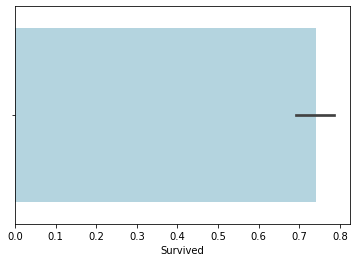

In [18]:

sns.barplot('Survived', data=titanic_train[titanic_train["Sex"]==1],color="lightblue")
plt.show()

## Survival Rate by Sex

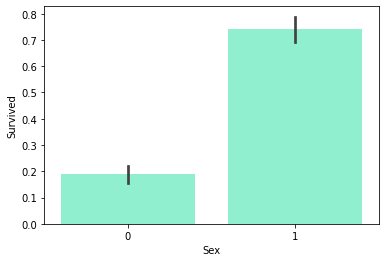

In [19]:
sns.barplot('Sex', 'Survived', data=titanic_train, color="aquamarine")
plt.show()

## Survival Rate by AgeCategory

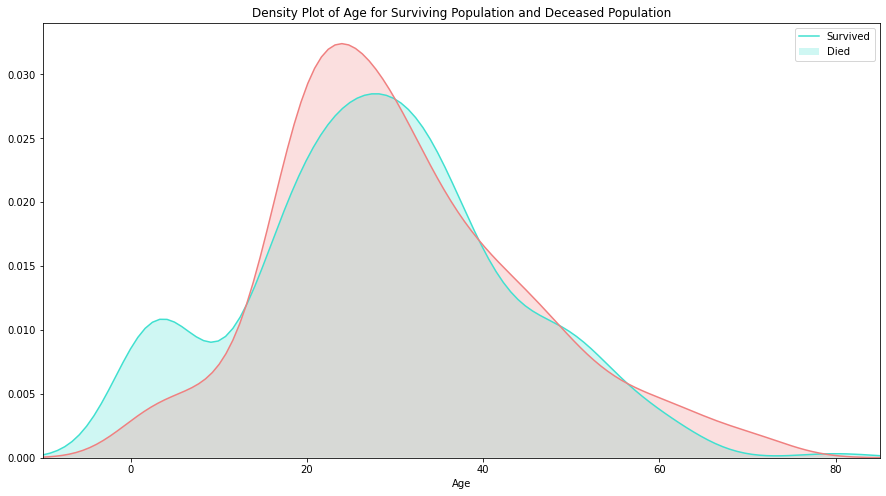

In [20]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(titanic_train["Age"][titanic_train.Survived == 1], color="turquoise", shade=True)
sns.kdeplot(titanic_train["Age"][titanic_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

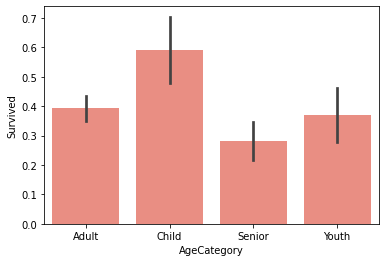

In [21]:
sns.barplot('AgeCategory', 'Survived', data=titanic_train, color="salmon")
plt.show()

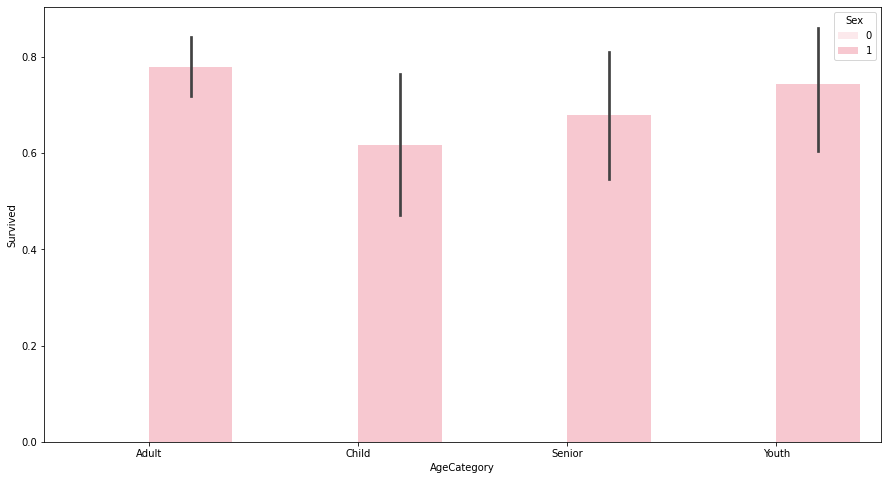

In [22]:
plt.figure(figsize=(15,8))
sns.barplot('AgeCategory', 'Survived',"Sex", data=titanic_train[titanic_train["Sex"]==1],color="pink")
plt.show()

## Survival Rate by Pclass

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

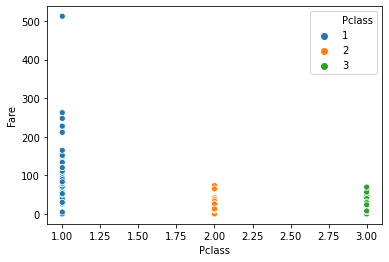

In [23]:
sns.scatterplot(data=titanic_train, x="Pclass", y="Fare", hue="Pclass")

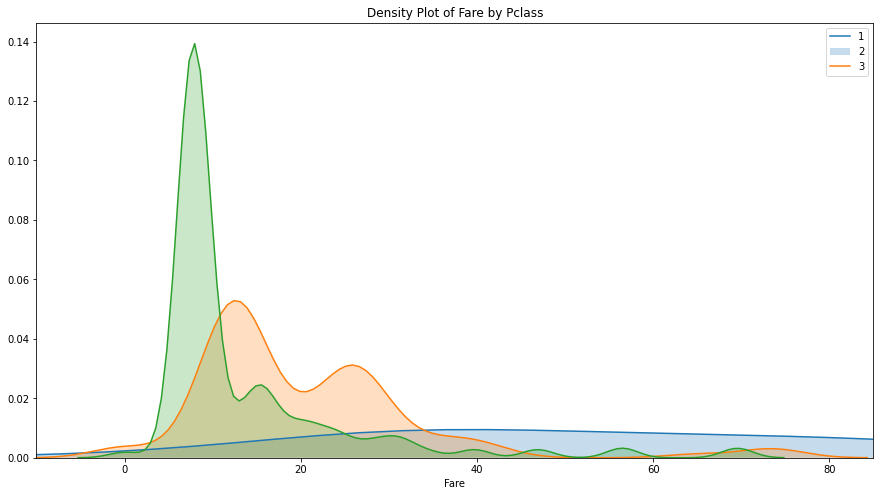

In [24]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(titanic_train["Fare"][titanic_train.Pclass == 1], shade=True)
sns.kdeplot(titanic_train["Fare"][titanic_train.Pclass == 2], shade=True)
sns.kdeplot(titanic_train["Fare"][titanic_train.Pclass == 3], shade=True)
plt.legend(['1', '2','3'])
plt.title('Density Plot of Fare by Pclass')
ax.set(xlabel='Fare')
plt.xlim(-10,85)
plt.show()

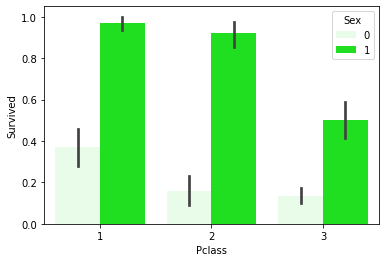

In [25]:
sns.barplot('Pclass', 'Survived',"Sex", data=titanic_train, color="lime")
plt.show()

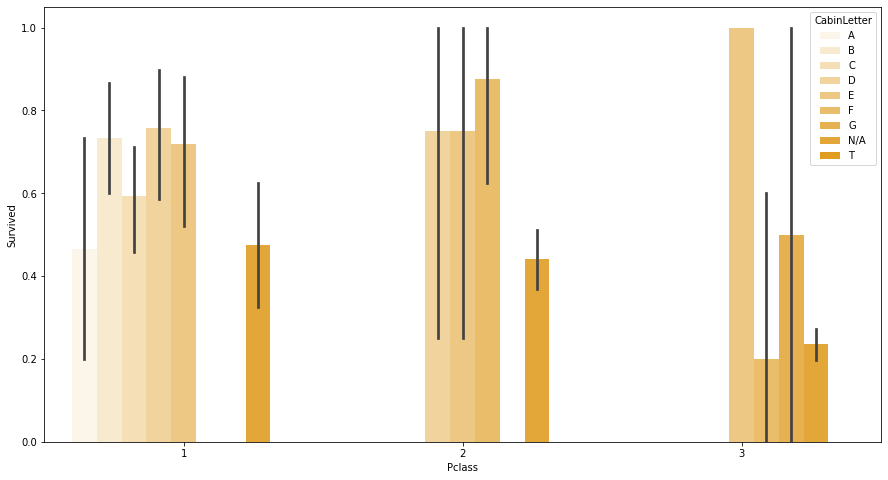

In [26]:
plt.figure(figsize=(15,8))
sns.barplot('Pclass', 'Survived',"CabinLetter", data=titanic_train,color="orange")
plt.show()

## Survival Rate by Cabin

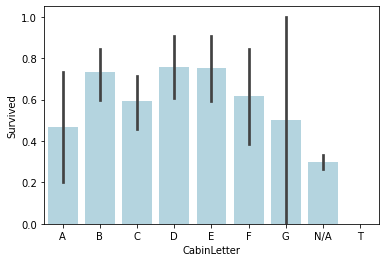

In [27]:
sns.barplot('CabinLetter', 'Survived', data=titanic_train, color="lightblue")
plt.show()

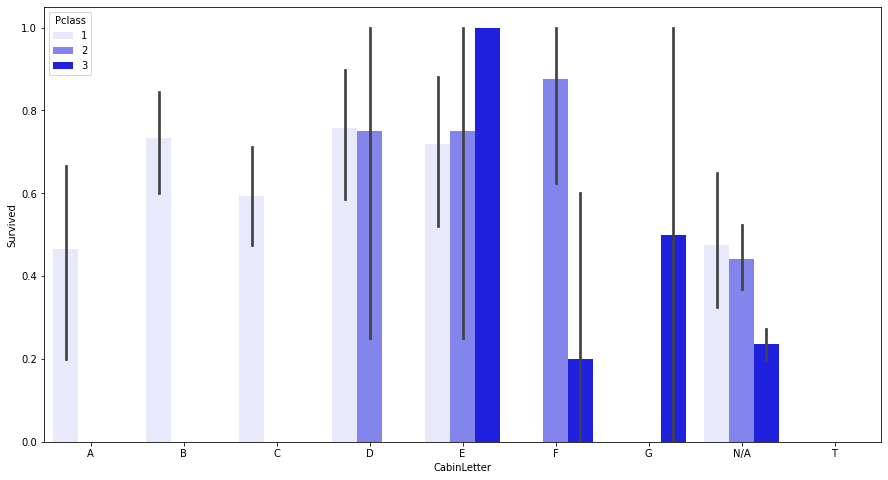

In [28]:
plt.figure(figsize=(15,8))
sns.barplot('CabinLetter', 'Survived',"Pclass", data=titanic_train,color="blue")
plt.show()

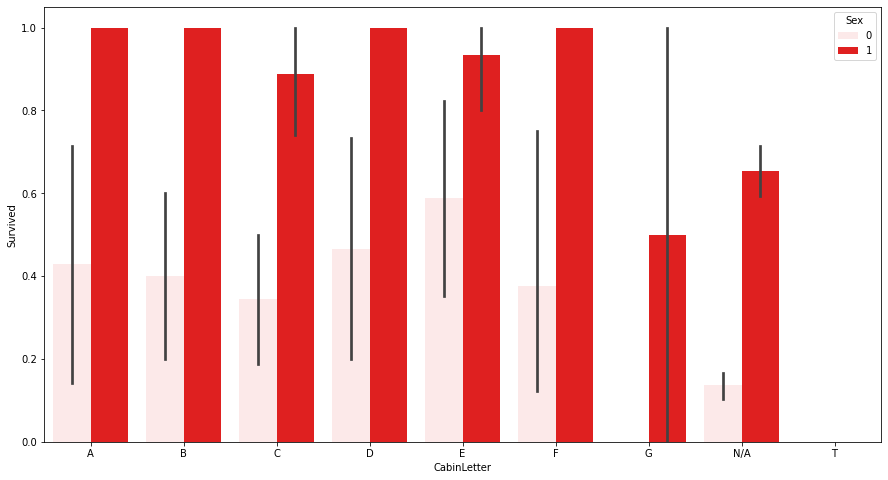

In [29]:
plt.figure(figsize=(15,8))
sns.barplot('CabinLetter', 'Survived',"Sex", data=titanic_train,color="red")
plt.show()

## Survival Rate by FamilyRole

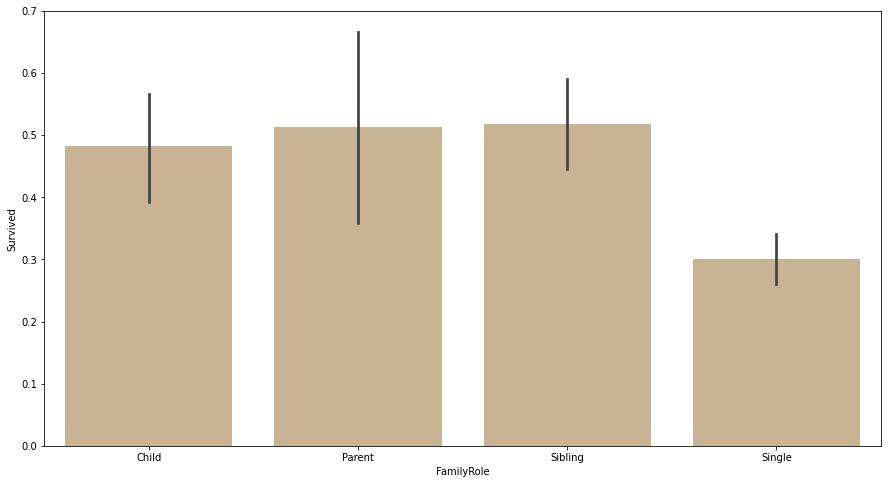

In [30]:
plt.figure(figsize=(15,8))
sns.barplot('FamilyRole', 'Survived', data=titanic_train,color="tan")
plt.show()

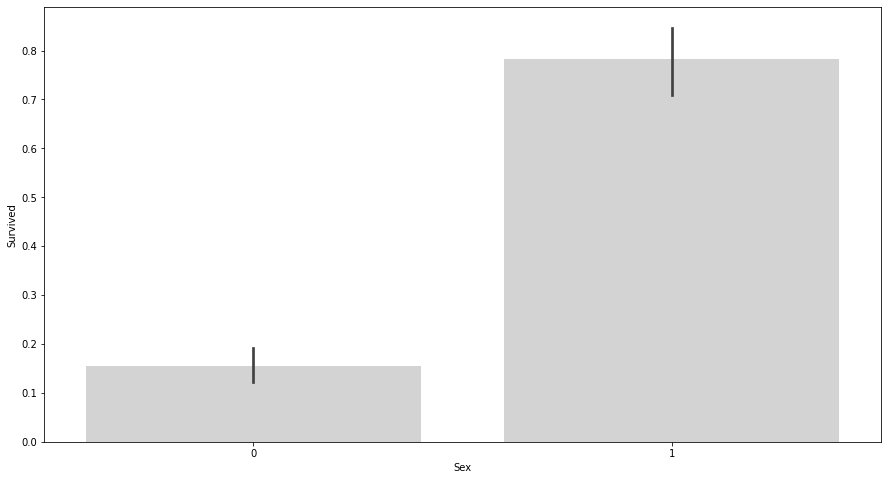

In [31]:
plt.figure(figsize=(15,8))
sns.barplot('Sex', 'Survived', data=titanic_train[titanic_train["FamilyRole"]=="Single"],color="lightgrey")
plt.show()

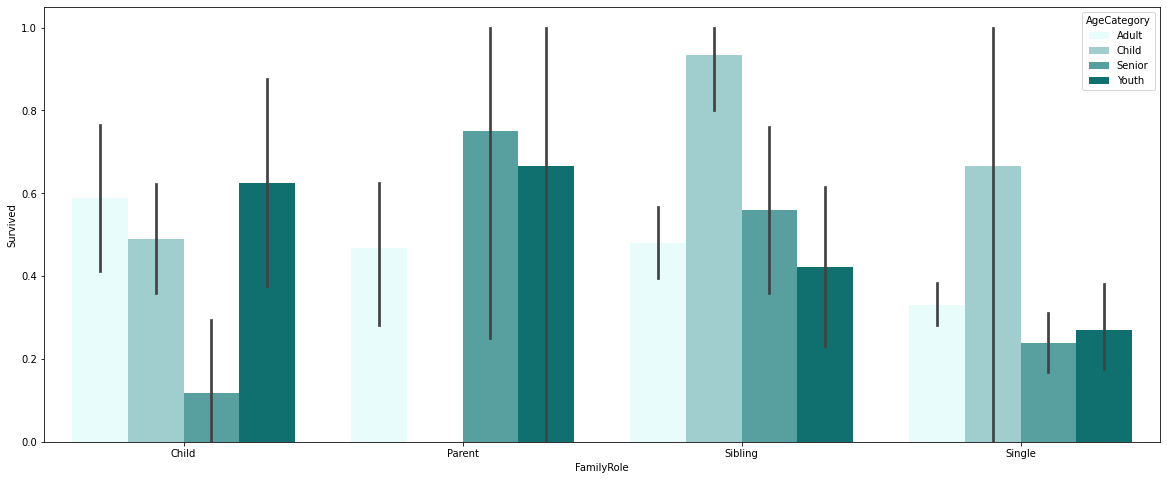

In [32]:
plt.figure(figsize=(20,8))
sns.barplot('FamilyRole', 'Survived',"AgeCategory", data=titanic_train,color="teal")
plt.show()

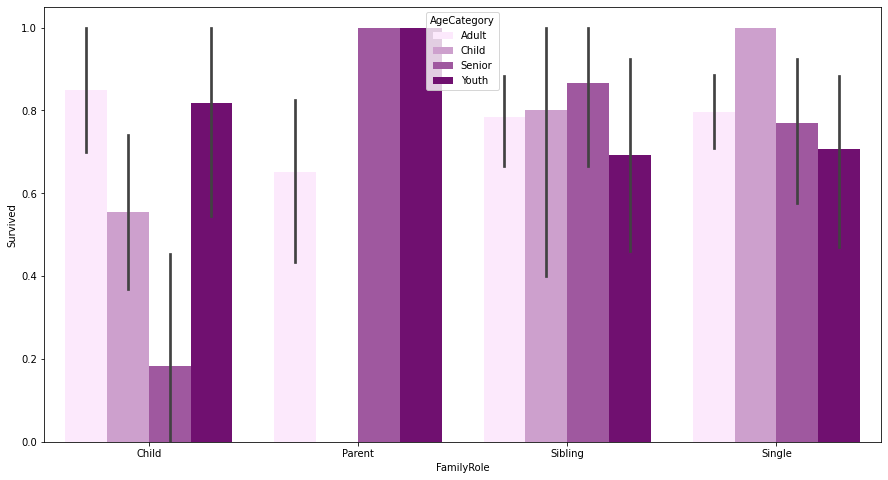

In [33]:
plt.figure(figsize=(15,8))
sns.barplot('FamilyRole', 'Survived',"AgeCategory", data=titanic_train[titanic_train["Sex"]==1],color="purple")
plt.show()

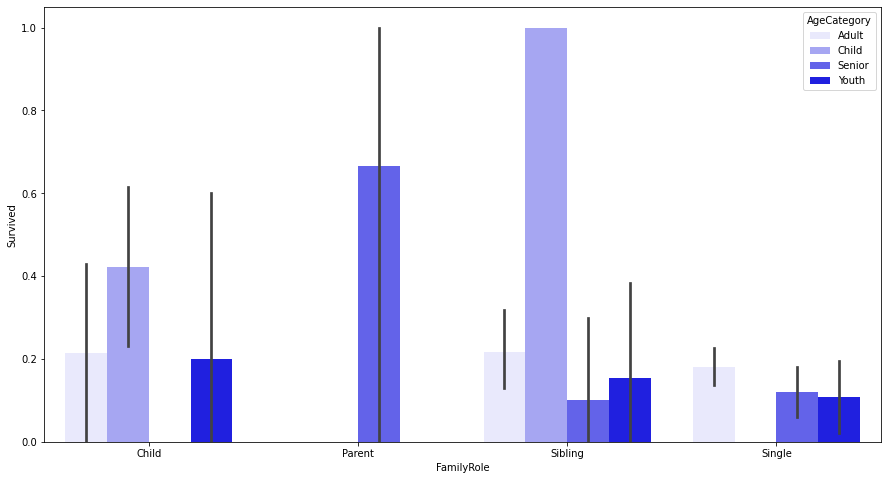

In [34]:
plt.figure(figsize=(15,8))
sns.barplot('FamilyRole', 'Survived',"AgeCategory", data=titanic_train[titanic_train["Sex"]==0],color="blue")
plt.show()

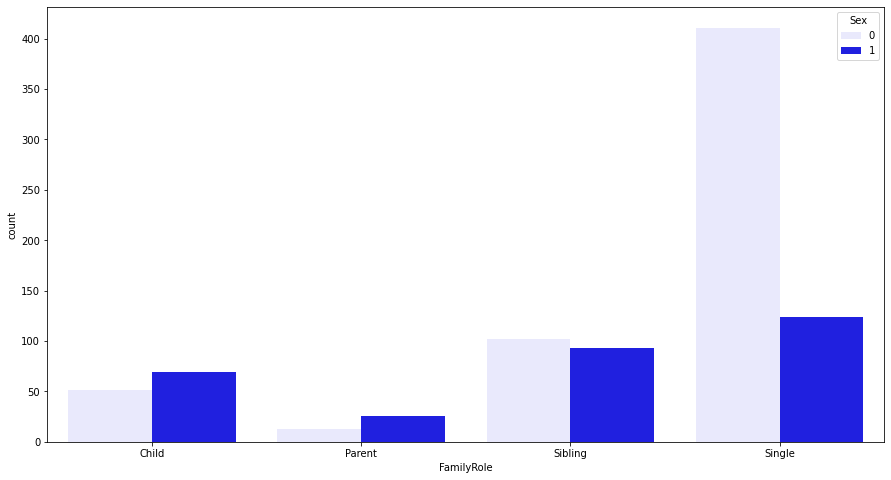

In [35]:
plt.figure(figsize=(15,8))
sns.countplot("FamilyRole",hue="Sex", data=titanic_train,color="blue")
plt.show()

## Model Training

In [36]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyRole,CabinLetter,Age_fill,AgeCategory
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Sibling,N/A,22.0,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Sibling,C,38.0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Single,N/A,26.0,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Sibling,C,35.0,Adult
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Single,N/A,35.0,Adult


In [37]:
#create categorical variables and drop some variables

titanic_train= pd.get_dummies(titanic_train, columns=["Pclass","Embarked","CabinLetter","FamilyRole","AgeCategory"])
cols_to_drop = ["PassengerId","Name","Age","SibSp","Parch","Ticket","Fare","Cabin","Age_fill"]
titanic_train.drop(cols_to_drop,axis=1,inplace=True)
titanic_train.head()

,Survived,Sex,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,CabinLetter_A,CabinLetter_B,...,CabinLetter_N/A,CabinLetter_T,FamilyRole_Child,FamilyRole_Parent,FamilyRole_Sibling,FamilyRole_Single,AgeCategory_Adult,AgeCategory_Child,AgeCategory_Senior,AgeCategory_Youth
0,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
1,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
3,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0


1) apply 1-2 different models
2) Look into PCA to determine optimal features 
3) Research model performance indicators (ROC curve, etc)

In [38]:
cols_to_drop = ["PassengerId","Name","Ticket"]
titanic_train_baseline.drop(cols_to_drop,axis=1,inplace=True)
titanic_train_baseline.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,0,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,0,1
4,0,0,35.0,0,0,8.0500,0,0,1,0,0,1


Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.510
LogisticRegression auc is 0.828


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:177: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


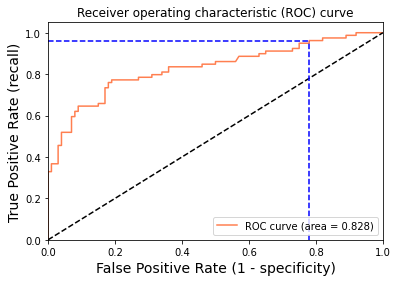

Using a threshold of 0.078 guarantees a sensitivity of 0.962 and a specificity of 0.220, i.e. a false positive rate of 78.00%.


In [39]:
logreg_base = log_reg_train(titanic_train_baseline)

Train/Test split results:
LogisticRegression accuracy is 0.798
LogisticRegression log_loss is 0.443
LogisticRegression auc is 0.858


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:177: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


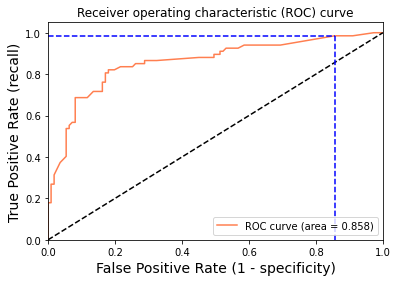

Using a threshold of 0.084 guarantees a sensitivity of 0.985 and a specificity of 0.144, i.e. a false positive rate of 85.59%.


In [40]:
logreg_alt = log_reg_train(titanic_train) 

Accuracy: 0.7821229050279329
Precision: 0.8448275862068966
Recall: 0.620253164556962


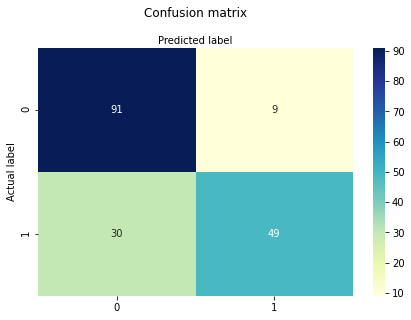

In [41]:
cnf_matrix(logreg_base,titanic_train_baseline)

Accuracy: 0.797752808988764
Precision: 0.7384615384615385
Recall: 0.7164179104477612


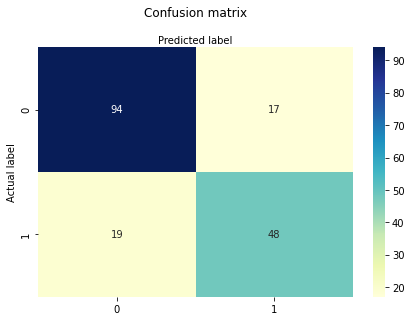

In [42]:
cnf_matrix(logreg_alt,titanic_train)

In [43]:
logreg = LogisticRegression()
rf = RandomForestClassifier()
gbm = GradientBoostingClassifier()

In [44]:
models = get_models(logreg)
evaluate_models(logreg,titanic_train)

Optimal number of features: 10
Selected features: ['Sex', 'Pclass_1', 'Pclass_3', 'Embarked_C', 'Embarked_S', 'CabinLetter_N/A', 'FamilyRole_Sibling', 'FamilyRole_Single', 'AgeCategory_Adult', 'AgeCategory_Child']
Removed features: ['Pclass_2', 'Embarked_Q', 'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D', 'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_G', 'CabinLetter_T', 'FamilyRole_Child', 'FamilyRole_Parent', 'AgeCategory_Senior', 'AgeCategory_Youth']


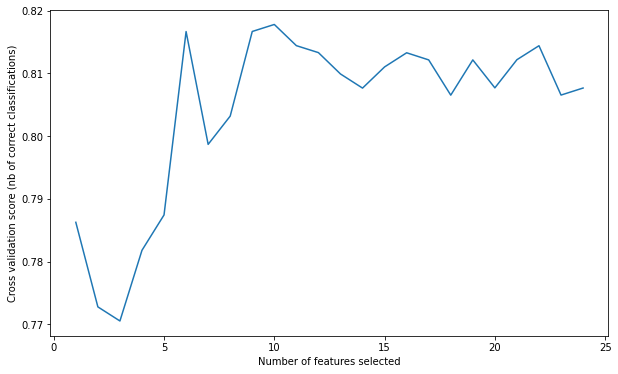

In [45]:
selected_features = feature_selection(titanic_train,rf)

In [46]:
titanic_train_selected = titanic_train.loc[:,selected_features]

Train/Test split results:
LogisticRegression accuracy is 0.820
LogisticRegression log_loss is 0.434
LogisticRegression auc is 0.865


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:177: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


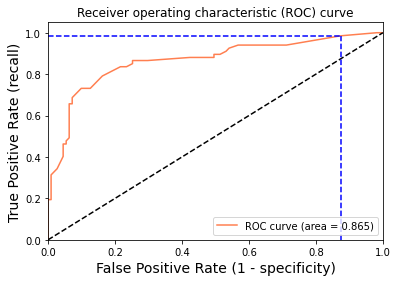

Using a threshold of 0.086 guarantees a sensitivity of 0.985 and a specificity of 0.126, i.e. a false positive rate of 87.39%.


In [47]:
logreg_selected = log_reg_train(titanic_train_selected)

Accuracy: 0.8202247191011236
Precision: 0.7611940298507462
Recall: 0.7611940298507462


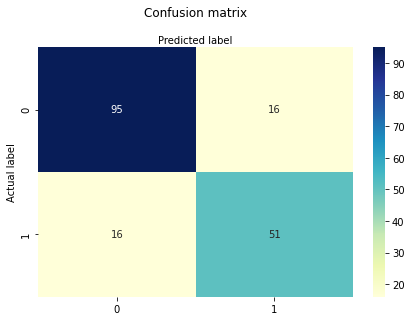

In [48]:
cnf_matrix(logreg_selected,titanic_train_selected)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8044692737430168


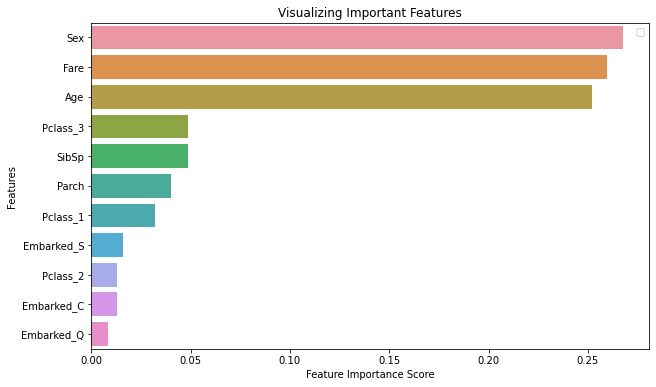

In [50]:
rf_train_base = rf_train(titanic_train_baseline)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.7865168539325843


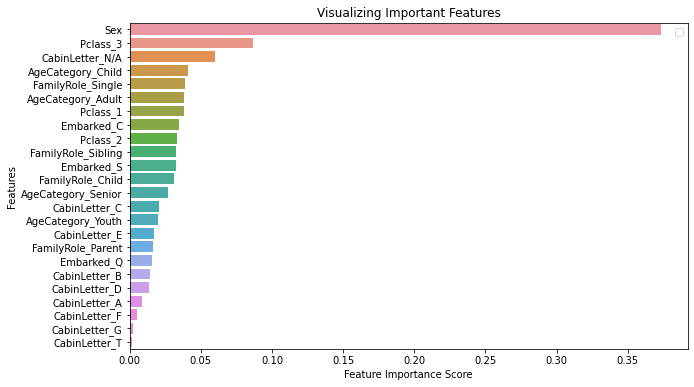

In [51]:
rf_train_alt = rf_train(titanic_train)

In [52]:
models = get_models(rf)
evaluate_models(rf,titanic_train)

>lr 0.806 (0.036)
>rf 0.802 (0.031)
>gbm 0.807 (0.035)


Optimal number of features: 6
Selected features: ['Sex', 'Pclass_3', 'CabinLetter_G', 'CabinLetter_N/A', 'FamilyRole_Child', 'AgeCategory_Child']
Removed features: ['Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D', 'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_T', 'FamilyRole_Parent', 'FamilyRole_Sibling', 'FamilyRole_Single', 'AgeCategory_Adult', 'AgeCategory_Senior', 'AgeCategory_Youth']


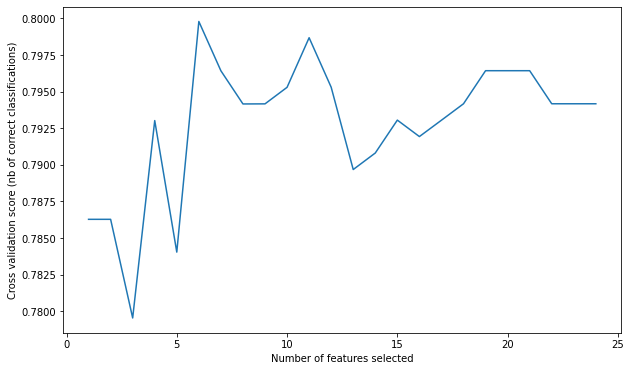

In [54]:
selected_features = feature_selection(titanic_train,logreg)

In [55]:
titanic_train_selected = titanic_train.loc[:,selected_features]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8089887640449438


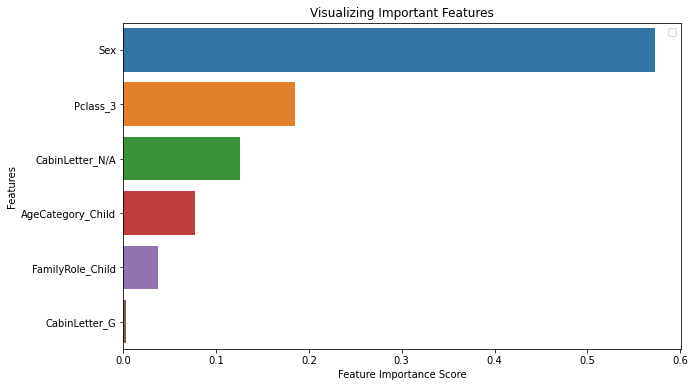

In [56]:
rf_train_selected = rf_train(titanic_train_selected)

Accuracy: 0.8089887640449438
Precision: 0.7894736842105263
Recall: 0.6716417910447762


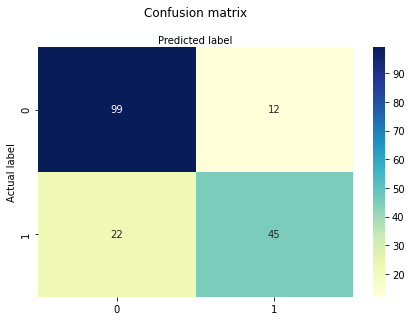

In [57]:
cnf_matrix(rf_train_selected,titanic_train_selected)

{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8089887640449438


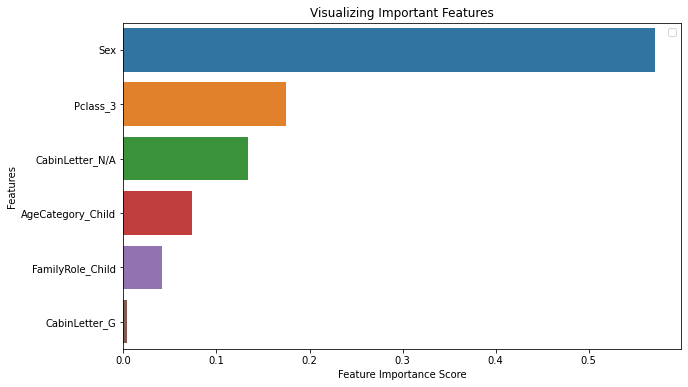

In [68]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rf_train_gs = rf_train(titanic_train_selected,gs=True,param_grid=param_grid)

Accuracy: 0.8089887640449438
Precision: 0.7894736842105263
Recall: 0.6716417910447762


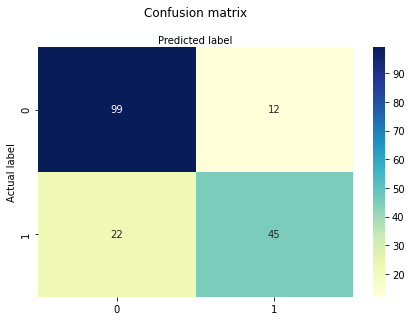

In [70]:
cnf_matrix(rf_train_gs,titanic_train_selected)